In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import ast

: 

# A) Company data
Include company info from LSEG to info from SRN
- retrieved all company data with the help of ISIN code from LSEG based on the companies from esrs_reports.xlsx
- merge them with SRN information

In [ ]:
company_data = pd.read_excel(
    "lseg_company_data.xlsx",
    na_values=["Unable to resolve some identifier(s).", "NULL"])
print(len(company_data))

In [ ]:
# drop rows where ISIN is missing
company_data = company_data.dropna(subset=['ISIN'])
print(len(company_data))

In [ ]:
# look if there are duplicate ISINs
company_data[company_data.duplicated(subset=['ISIN'], keep=False)]

In [ ]:
### only look at companies where inference was run

# read in all_results.jsonl
all_results = pd.read_json("all_results.jsonl", lines=True)
all_results = all_results[~all_results.duplicated(subset=['report_id'], keep='first')] # for 10 reports inference was run twice
# delete reports that have missings in the inference
missings_rep = ['Genmab_2024', 'Alk-Abello_2024', 'Repsol_2024', 'K+S_2024', 'TeliaCompany_2024', 'HapagLloyd_2024', 'Outokumpu_2024', 'SSAB_2024', 'TGSNOPECGeophysicalCo_2024']
all_results = all_results[~all_results['report_id'].isin(missings_rep)]
print(len(all_results))

# read in srn_infos
srn_infos = pd.read_excel("esrs_reports.xlsx")

# keep only rows where report_id is in all_results
srn_infos = srn_infos[srn_infos['report_id'].isin(all_results['report_id'])]
print(len(srn_infos))

In [ ]:
# join srn_infos with company_data on isin
merged_info = srn_infos.merge(company_data, left_on='isin', right_on='ISIN', how='left')
print(len(merged_info))

In [ ]:
# when Number of Employees from CSR reporting is missing, fill it with Number of Employees from LSEG
merged_info['number_employees'] = merged_info['Number of Employees  from CSR reporting'].fillna(merged_info['Number of Employees'])
print("Number of missings in employee number", merged_info['number_employees'].isna().sum())

# drop columns 'Number of Employees  from CSR reporting' and 'Number of Employees'
merged_info = merged_info.drop(columns=['Number of Employees  from CSR reporting', 'Number of Employees'])

# drop all companys with less than 750 employees
merged_info = merged_info[merged_info['number_employees'] >= 750]
print("Number of companies with 750 employees or more:", len(merged_info))

## 1. Control for mismatches SRN and LSEG info
### 1.1 Country of the company

In [ ]:
# print all rows where country and Country of Headquarters are not the same
mismatched_country = merged_info[merged_info['country'] != merged_info['Country of Headquarters']]

# keep only relevant columns: Company Name, country, Country of Headquarters, Incorp. Region Code
mismatched_country = mismatched_country[['company', 'Company Common Name', 'ISIN', 'country', 'Country of Headquarters', 'Incorp. Region Code']]

print(mismatched_country)

found mistake:
company: Ferrovial SE ISIN: NL0015001FS8 --> Netherlands (not Spain)

In [ ]:
# for ISIN: NL0015001FS8 change country from Spain to Netherlands in merged_info
merged_info.loc[merged_info['ISIN'] == 'NL0015001FS8', 'country'] = 'Netherlands'

print(merged_info[merged_info['ISIN'] == 'NL0015001FS8'])

In [ ]:
# drop unnecessary columns
merged_info = merged_info.drop(columns=['Country of Headquarters', 'Incorp. Region Code'])

### 1.2 Company names

In [ ]:
# look at all mismatches in the names
    # 1. prepare standardizes names (remove sa, se, nv, ag, a/s)

def standardize_name(name):
    name = name.lower()
    name = name.replace(" sa", "").replace(" se", "").replace(" nv", "").replace(" ag", "").replace(" a/s", "").replace(" oyj", "").replace(" ab", "").replace(" abp", "").replace(" plc", "").replace(" spa", "").replace(" asa", "").replace(" nyrt", "").replace(" holding", "").replace(" group", "")
    name = name.strip()
    return name

# compare standardized "company" and "Company Common Name"
merged_info['srn_company_std'] = merged_info['company'].apply(standardize_name)
merged_info['lseg_company_std'] = merged_info['Company Common Name'].apply(standardize_name)
mismatched_names = merged_info[merged_info['srn_company_std'] != merged_info['lseg_company_std']]
mismatched_names = mismatched_names[['ISIN', 'link', 'company', 'Company Common Name', 'srn_company_std', 'lseg_company_std']]
print(mismatched_names)

found mismatches in Company: Cargotec, ISIN: FI4000571013

In [ ]:
# drop row of ISIN: FI4000571013
merged_info = merged_info[merged_info['ISIN'] != 'FI4000571013']

# drop unnecessary columns
merged_info = merged_info.drop(columns=['srn_company_std', 'lseg_company_std', 'company'])
# rename column 'Company Common Name' to 'company_name'
merged_info = merged_info.rename(columns={'Company Common Name': 'company_name'})

print(len(merged_info))

## 2. Look at missings

In [ ]:
# for every column print number of missings
for column in merged_info.columns:
    num_missing = merged_info[column].isna().sum()
    print(f"'{column}' has {num_missing} missing values")

In [ ]:
# drop rows where Company Market Capitalization is missing
merged_info = merged_info.dropna(subset=['Company Market Capitalization'])
print(len(merged_info))

# 2. Company descriptives

### 2.1 Per industry & country

In [ ]:
# Count companies per sector
sector_counts = (
    merged_info["SASB_industry"]
    .value_counts()
    .reset_index()
)
sector_counts.columns = ["Sector", "Count"]

# Sort sectors so highest count is first
sector_counts = sector_counts.sort_values("Count", ascending=True).reset_index(drop=True)

# Create color palette from light to dark red (highest count = darkest red)
colors = sns.color_palette("Reds", n_colors=len(sector_counts))

# Assign colors based on sorted order
color_map = dict(zip(sector_counts["Sector"], colors))
bar_colors = sector_counts["Sector"].map(color_map)

# Plot (horizontal bar chart)
fig, ax = plt.subplots(figsize=(10, 12))
bars = ax.barh(
    y=sector_counts["Sector"],
    width=sector_counts["Count"],
    color=bar_colors
)

# Add counts at the end of each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
            f"{int(width)}",
            va="center", ha="left", fontsize=10)

# Style
ax.set_title("Number of Companies per GICS Sector", fontsize=14, weight="bold")
ax.set_xlabel("")  # remove x-axis label
ax.xaxis.set_visible(False)  # hide x-axis ticks and labels
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.grid(False)  # remove grid lines

plt.tight_layout()
plt.show()

Sustainable Industry Classification System (SICS), was developed by the Sustainability Accounting Standards Board (SASB) to group companies into sectors with comparable exposure to sustainability-related risks and opportunities. Due to the sample size the companies are very fractured across the sectors. Therefore, I am differntiating with the GICS Sectors. 

In [ ]:
import textwrap
import geopandas as gpd

# --- Map preparation ---
world = gpd.read_file("earth/ne_110m_admin_0_countries.shp")
europe = world[world['CONTINENT'] == 'Europe']

country_counts = merged_info["country"].value_counts().reset_index()
country_counts.columns = ["country", "count"]

europe_counts = europe.merge(country_counts, left_on="NAME", right_on="country", how="left")
europe_counts["count"] = europe_counts["count"].fillna(0)

# --- Sector preparation ---
sector_counts = (
    merged_info["GICS Sector Name"]
    .value_counts()
    .reset_index()
)
sector_counts.columns = ["Sector", "Count"]

sector_counts = sector_counts.sort_values("Count", ascending=True).reset_index(drop=True)

colors = sns.color_palette("Reds", n_colors=len(sector_counts))
color_map = dict(zip(sector_counts["Sector"], colors))
bar_colors = sector_counts["Sector"].map(color_map)

# --- Combined figure ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1.2, 1]})

# --- Left: Map ---
cmap = cm.Reds
norm = mcolors.Normalize(vmin=europe_counts["count"].min(), vmax=europe_counts["count"].max())

europe_counts.plot(
    column='count',
    cmap=cmap,
    norm=norm,
    edgecolor='black',
    linewidth=0.2,
    ax=ax1,
    legend=True,
    legend_kwds={
        "label": "# Companies",
        "orientation": "horizontal",
        "shrink": 0.6,
        "pad": 0.02
    },
    missing_kwds={
        "color": "white",
        "edgecolor": "black"
    }
)

for idx, row in europe_counts.iterrows():
    if row["count"] > 0:
        x, y = row.geometry.representative_point().coords[0]
        ax1.text(x, y, int(row["count"]), ha="center", va="center", fontsize=9, color="black")

ax1.set_xlim(-15, 35)
ax1.set_ylim(32, 72)
ax1.axis('off')
ax1.set_title("Number of companies per country", fontsize=14, weight="bold")

# --- Right: Bar chart ---

# Wrap sector names (e.g., break after ~20 chars)
sector_counts["Sector_wrapped"] = sector_counts["Sector"].apply(
    lambda x: "\n".join(textwrap.wrap(x, width=20))
)

# Right: Bar chart with wrapped labels
bars = ax2.barh(
    y=sector_counts["Sector_wrapped"],
    width=sector_counts["Count"],
    color=bar_colors
)

for bar in bars:
    width = bar.get_width()
    ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f"{int(width)}",
             va="center", ha="left", fontsize=10)

ax2.set_title("Number of companies per GICS sector", fontsize=14, weight="bold")
ax2.set_xlabel("")
ax2.xaxis.set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.grid(False)


In [ ]:
# prepare list of companies by name and country, grouped by SICS sector

# Make sure we have only relevant columns
subset = merged_info[["company_name", "country", "GICS Sector Name"]].copy()

# Sort by sector, then by country, then by company
subset = subset.sort_values(by=["GICS Sector Name", "country", "company_name"])

# export subset to excel
subset.to_excel("company_list.xlsx", index=False)

## 2.2 Descriptives of used variables

In [ ]:
# descriptive table with min, max, mean, median, std about: Company Market Capitalization, Number of Employees, social pillar score, workforce score
desc_table = merged_info[['Company Market Capitalization', 'number_employees', 'Social Pillar Score', 'Workforce Score']].describe()
print(desc_table)

In [ ]:
# Select the columns you want
cols = [
    "Company Market Capitalization",
    "Total Assets - Mean",
    "number_employees",
    "ESG Score",
    "ESG Combined Score",
    "Social Pillar Score",
    "Workforce Score",
    "CSR Sustainability Reporting Score",
    "Company Green Revenue Percentage",
    "Estimated EU Taxonomy Aligned Company Green Revenue Percentage",

]

# Calculate descriptive statistics
desc_table = pd.DataFrame({
    "Min": merged_info[cols].min(),
    "Max": merged_info[cols].max(),
    "Mean": merged_info[cols].mean(),
    "Median": merged_info[cols].median(),
    "Std Dev": merged_info[cols].std(),
    "Total Observations": merged_info[cols].count(),
})


# Optional: Rename index to nice format
desc_table.index.name = "Variable"

# round all values to 2 decimal places
desc_table = desc_table.round(2)

# Display table
desc_table

# save as an excel file
desc_table.to_excel("descriptive_statistics.xlsx")

# B) Inference results

In [ ]:
# read in all_results.jsonl
all_results = pd.read_json("all_results.jsonl", lines=True)
all_results = all_results[~all_results.duplicated(subset=['report_id'], keep='first')] # for 10 reports inference was run twice
print(len(all_results))

In [ ]:
# keep only report_ids that are in merged_info
all_results = all_results[all_results['report_id'].isin(merged_info['report_id'])]
print(len(all_results))

In [ ]:
print(all_results.head())

In [ ]:
binary_data = []

for _, row in all_results.iterrows():
    report = row["report_id"]
    
    # result column is a string of dict → convert safely
    results_dict = row["result"]
    
    for indicator, info in results_dict.items():
        verdict = info.get("verdict", None)   # None if missing
        analysis = info.get("analysis", None)
        
        # Assign binary disclosure
        if verdict == "YES":
            disclosure_status = 1
        elif verdict == "NO":
            disclosure_status = 0
        else:
            disclosure_status = np.nan
            print(f"Missing verdict in report {report}, indicator {indicator}")
            print("Verdict:", verdict)
            print("Analysis:", analysis, "\n")
        
        # Define topic (e.g. S1_A1 → A, S1_B3 → B)
        topic = indicator[3]
        
        binary_data.append({
            "report_id": report,
            "indicator": indicator,
            "topic": topic,
            "disclosure_status": disclosure_status
        })

# Create disclosure matrix DataFrame
df_disclosure = pd.DataFrame(binary_data)

In [ ]:
# drop all results where inference has a missing verdict
missings_rep = ['Genmab_2024', 'Alk-Abello_2024', 'Repsol_2024', 'K+S_2024', 'TeliaCompany_2024', 'HapagLloyd_2024', 'Outokumpu_2024', 'SSAB_2024', 'TGSNOPECGeophysicalCo_2024']

df_disclosure = df_disclosure[~df_disclosure['report_id'].isin(missings_rep)]
# count number of unique report_ids
print("Number of reports after dropping missings:", df_disclosure['report_id'].nunique())


In [ ]:
# --- 1. Report-Level Disclosure ---
report_disclosure = (
    df_disclosure
    .groupby("report_id")["disclosure_status"]
    .mean()
    .mul(100)
    .reset_index(name="report_disclosure")
)

# --- 2. Topic-Level Disclosure ---
topic_disclosure = (
    df_disclosure
    .groupby(["report_id", "topic"])["disclosure_status"]
    .mean()
    .mul(100)
    .reset_index()
    .pivot(index="report_id", columns="topic", values="disclosure_status")
)

# Rename columns to e.g. A_disclosure, B_disclosure, ...
topic_disclosure = topic_disclosure.add_suffix("_disclosure").reset_index()

# --- 3. Combine into one aggregated dataset ---
aggregated_disclosure = report_disclosure.merge(topic_disclosure, on="report_id", how="left")

# Ergebnis anschauen
print(aggregated_disclosure.head())


In [ ]:
# print the analysis for all reports with 0 report_disclosure and look at the analysis
zero_reports = aggregated_disclosure[aggregated_disclosure['report_disclosure'] == 0.0]

zero_reports_analysis = all_results[all_results['report_id'].isin(zero_reports['report_id'])]

looked at the inference results, no anomalites were obvious

### 1. Descriptives all companies

In [ ]:
topic_labels = {
    "A_disclosure": "A: management and disclosure of material impacts, risks and opportunities",
    "B_disclosure": "B: material risks and opportunities arising from dependencies on own workforce",
    "C_disclosure": "C: human rights practices, risks and incidents",
    "D_disclosure": "D: processes and policies for engaging with own workforce about impacts",
    "E_disclosure": "E: policies on non-discrimination, diversity and inclusion",
    "F_disclosure": "F: approaches to remediate negative impacts and channels to raise concerns",
    "G_disclosure": "G: social protection coverage"
}

In [ ]:
# --- calculate means ---
mean_values = aggregated_disclosure.mean(numeric_only=True)

# --- split overall and topics ---
overall_value = mean_values["report_disclosure"]
topic_values = mean_values[topic_labels.keys()]


# --- add overall and topics ---
plot_values = [overall_value] + list(topic_values.values)
plot_labels = ["Overall disclosure"] + [topic_labels[col] for col in topic_values.index]

# --- labels in two lines ---
wrapped_labels = [textwrap.fill(label, width=40) for label in plot_labels]

# --- define colors ---
colors = ["#900A12"] + ["#E32F27"] * len(topic_values)

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(wrapped_labels, plot_values, color=colors)

# --- add numbers on bars ---
for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            f"{width:.1f}%", va="center", ha="left", fontsize=9)

# --- layout ---
ax.set_xlim(0, 100)
ax.set_xlabel("Mean Disclosure Degree")
ax.set_title("ESRS S1 mean disclosure degree by topic", fontsize=14, weight="bold")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.invert_yaxis()

plt.tight_layout()
plt.show()


In [ ]:
# --- Data ---
data = aggregated_disclosure["report_disclosure"].dropna()

# --- Style setup to match the bar chart ---
sns.set_style("white")  # remove gray Seaborn background

fig, ax = plt.subplots(figsize=(10, 6))

# --- Histogram with relative frequency in % ---
sns.histplot(
    data,
    bins=15,
    stat="percent",      # show relative frequencies
    color="#900A12",     # same as overall disclosure color
    alpha=1.0,
    edgecolor="white",   # clean bar separation
    ax=ax
)

# --- Layout and aesthetics to match ---
ax.set_xlim(0, 100)
ax.set_xlabel("Mean Disclosure Degree", fontsize=11)
ax.set_ylabel("Frequency (%)", fontsize=11)
ax.set_title("Distribution of the disclosure degree by report", fontsize=14, weight="bold")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.set_facecolor("white")

plt.tight_layout()
plt.show()

In [ ]:
# --- Define the disclosure columns ---
disclosure_cols = ["report_disclosure", "A_disclosure", "B_disclosure", "C_disclosure",
                   "D_disclosure", "E_disclosure", "F_disclosure", "G_disclosure"]

n_reports = len(aggregated_disclosure)
print("Number of reports:", n_reports)

# --- Compute statistics ---
summary_table = pd.DataFrame({
    "Mean": aggregated_disclosure[disclosure_cols].mean(),
    "Std": aggregated_disclosure[disclosure_cols].std(),
    "Min": aggregated_disclosure[disclosure_cols].min(),
    "% (of zero)": (aggregated_disclosure[disclosure_cols].eq(0).sum() / n_reports * 100),
    "Max": aggregated_disclosure[disclosure_cols].max()
})

# --- Optional: round values for readability ---
summary_table = summary_table.round(2)

# --- Rename the index for nicer display ---
summary_table.index = [
    "Overall disclosure",
    "A: management and disclosure of material impacts, risks and opportunities",
    "B: material risks and opportunities arising from dependencies on own workforce",
    "C: human rights practices, risks and incidents",
    "D: processes and policies for engaging with own workforce about impacts",
    "E: policies on non-discrimination, diversity and inclusion",
    "F: approaches to remediate negative impacts and channels to raise concerns",
    "G: social protection coverage"
]

# --- Display table ---
display(summary_table)

# save as an excel file
summary_table.to_excel("disclosure_summary.xlsx")


In [ ]:
# --- Calculate disclosure rate per indicator ---
indicator_summary = (
    df_disclosure.groupby("indicator")["disclosure_status"]
    .mean() * 100  # convert to percentage
)

# --- Sort indicators by disclosure rate ---
indicator_summary = indicator_summary.sort_values(ascending=False)

# --- Top 5 most disclosed indicators ---
top5_disclosed = indicator_summary.head(5).reset_index()
top5_disclosed.columns = ["Indicator", "Disclosure (%)"]

# --- Bottom 5 least disclosed indicators ---
bottom5_disclosed = indicator_summary.tail(5).reset_index()
bottom5_disclosed.columns = ["Indicator", "Disclosure (%)"]

# --- Round for nicer presentation ---
top5_disclosed["Disclosure (%)"] = top5_disclosed["Disclosure (%)"].round(1)
bottom5_disclosed["Disclosure (%)"] = bottom5_disclosed["Disclosure (%)"].round(1)

# --- Display results ---
print(" 5 Most Disclosed Indicators")
display(top5_disclosed)

print("\n 5 Least Disclosed Indicators")
display(bottom5_disclosed)


### 2. Per sector

In [ ]:
# join aggregated_disclosure with merged_info on report_id
aggregated_disclosure = aggregated_disclosure.merge(merged_info, on="report_id", how="left")
print(len(aggregated_disclosure))

In [ ]:
# --- 2. Mittelwert pro Sektor berechnen ---
sector_means = (
    aggregated_disclosure.groupby("GICS Sector Name")["report_disclosure"]
    .mean()
    .sort_values(ascending=False)
)

# --- 3. Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(sector_means.index, sector_means.values, color="#900A12")

# Werte an die Balken schreiben
for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            f"{width:.1f}%", va="center", ha="left", fontsize=9)

# Layout
ax.set_xlim(0, 100)
ax.set_xlabel("Mean Disclosure Degree")
ax.set_title("Overall Disclosure Degree per GICS Sector", fontsize=14, weight="bold")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="x", linestyle="--", alpha=0.6)
ax.invert_yaxis()  # Höchster Wert oben

plt.tight_layout()
plt.show()


In [ ]:
# --- 1. Mean and count per sector ---
sector_stats = (
    aggregated_disclosure.groupby("GICS Sector Name")["report_disclosure"]
    .agg(["mean", "count"])
    .sort_values("mean", ascending=False)
)

# Create labels like: "Consumer Goods\n(n=15)"
sector_labels = [f"{sector}\n(n={count})" for sector, count in zip(sector_stats.index, sector_stats["count"])]

# --- 2. Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(sector_labels, sector_stats["mean"], color="#900A12")

# Add values at the end of bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            f"{width:.1f}%", va="center", ha="left", fontsize=9)

# --- 3. Layout ---
ax.set_xlim(0, 100)
ax.set_xlabel("Mean Disclosure Degree")
ax.set_title("Overall Disclosure Degree per GICS Sector", fontsize=14, weight="bold")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="x", linestyle="--", alpha=0.6)
ax.invert_yaxis()  # highest value on top

plt.tight_layout()
plt.show()


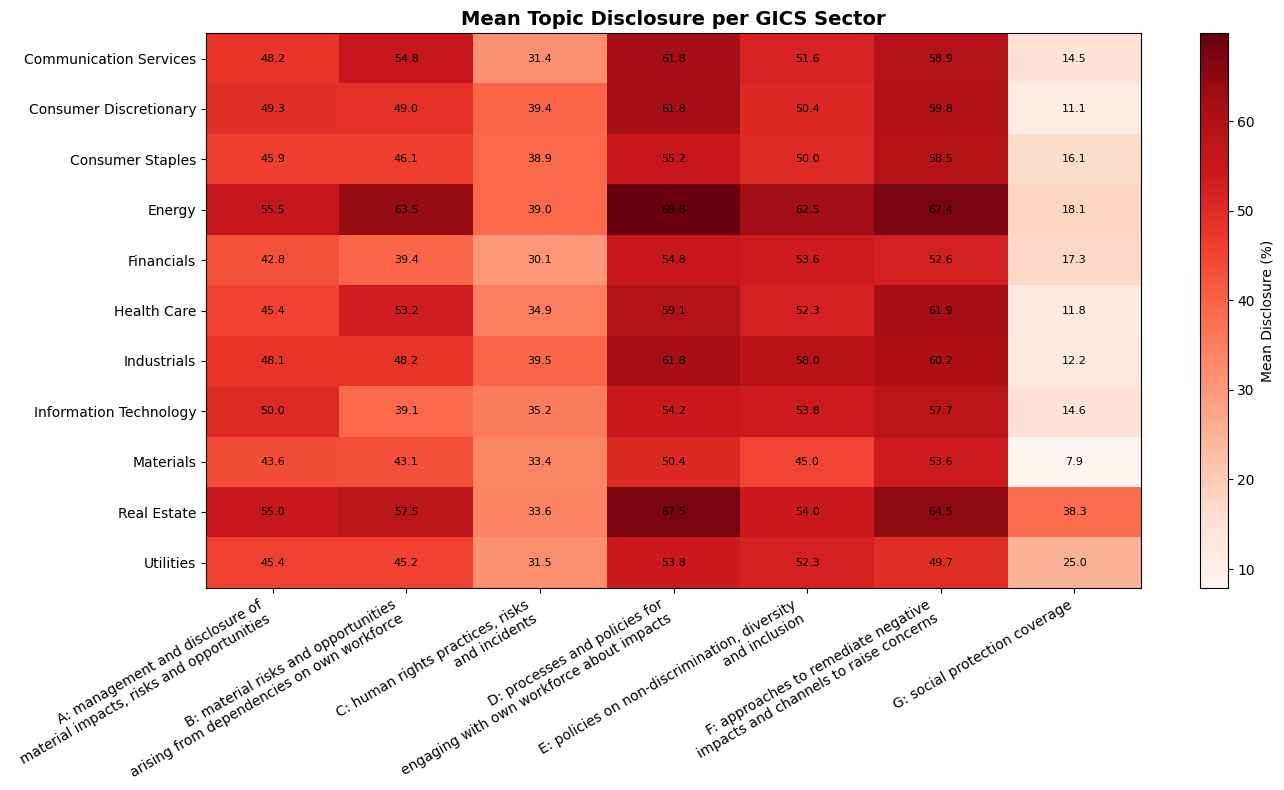

In [ ]:
# --- 2. Mittelwerte je Sektor und Topic ---
topic_cols = ["A_disclosure", "B_disclosure", "C_disclosure", 
              "D_disclosure", "E_disclosure", "F_disclosure", "G_disclosure"]

sector_topic_means = (
    aggregated_disclosure.groupby("GICS Sector Name")[topic_cols]
    .mean()
    .sort_index()
)

# --- 3. Heatmap-Plot ---
fig, ax = plt.subplots(figsize=(14, 8))  # etwas breiter für lange Labels
cmap = cm.Reds
im = ax.imshow(sector_topic_means, cmap=cmap, aspect="auto")

# Funktion zum Teilen von Strings nach 5 Wörtern
def split_label(label, n_words=5):
    words = label.split()
    if len(words) > n_words:
        return ' '.join(words[:n_words]) + '\n' + ' '.join(words[n_words:])
    return label

# Achsen-Beschriftungen mit geteilten topic_labels
split_topic_labels = [split_label(topic_labels[col]) for col in topic_cols]
ax.set_xticks(range(len(topic_cols)))
ax.set_xticklabels(split_topic_labels, rotation=30, ha="right", fontsize=10)

ax.set_yticks(range(len(sector_topic_means.index)))
ax.set_yticklabels(sector_topic_means.index)

# Farbskala
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Mean Disclosure (%)")

# Werte in die Zellen schreiben
for i in range(sector_topic_means.shape[0]):
    for j in range(sector_topic_means.shape[1]):
        value = sector_topic_means.iloc[i, j]
        ax.text(j, i, f"{value:.1f}", ha="center", va="center", color="black", fontsize=8)

ax.set_title("Mean Topic Disclosure per GICS Sector", fontsize=14, weight="bold")

plt.tight_layout()
plt.show()


## 3. Per country

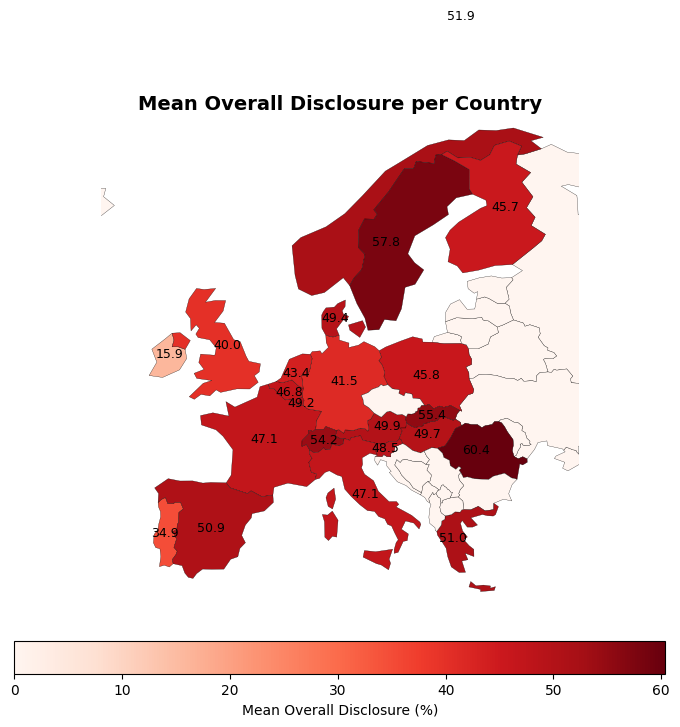

In [101]:
# Compute mean overall disclosure per country
country_disclosure = (
    aggregated_disclosure.groupby("country")["report_disclosure"] 
    .mean()
    .reset_index()
)
country_disclosure.columns = ["country", "mean_disclosure"]

# Merge with europe map
europe_disclosure = europe.merge(country_disclosure, left_on="NAME", right_on="country", how="left")

# Fill missing values with 0 or NaN (optional)
europe_disclosure["mean_disclosure"] = europe_disclosure["mean_disclosure"].fillna(0)

# --- Map plot ---
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
cmap = cm.Reds
norm = mcolors.Normalize(vmin=europe_disclosure["mean_disclosure"].min(), 
                         vmax=europe_disclosure["mean_disclosure"].max())

europe_disclosure.plot(
    column='mean_disclosure',
    cmap=cmap,
    norm=norm,
    edgecolor='black',
    linewidth=0.2,
    ax=ax,
    legend=True,
    legend_kwds={
        "label": "Mean Overall Disclosure (%)",
        "orientation": "horizontal",
        "shrink": 0.6,
        "pad": 0.02
    },
    missing_kwds={
        "color": "white",
        "edgecolor": "black"
    }
)

# Optionally, add values on the map
for idx, row in europe_disclosure.iterrows():
    if row["mean_disclosure"] > 0:
        x, y = row.geometry.representative_point().coords[0]
        ax.text(x, y, f"{row['mean_disclosure']:.1f}", ha="center", va="center", fontsize=9, color="black")

ax.set_xlim(-15, 35)
ax.set_ylim(32, 72)
ax.axis('off')
ax.set_title("Mean Overall Disclosure per Country", fontsize=14, weight="bold")

plt.show()


## 4. by size

C:\Users\julia\AppData\Local\Temp\ipykernel_17772\2797315495.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\julia\AppData\Local\Temp\ipykernel_17772\2797315495.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\julia\AppData\Local\Temp\ipykernel_17772\2797315495.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


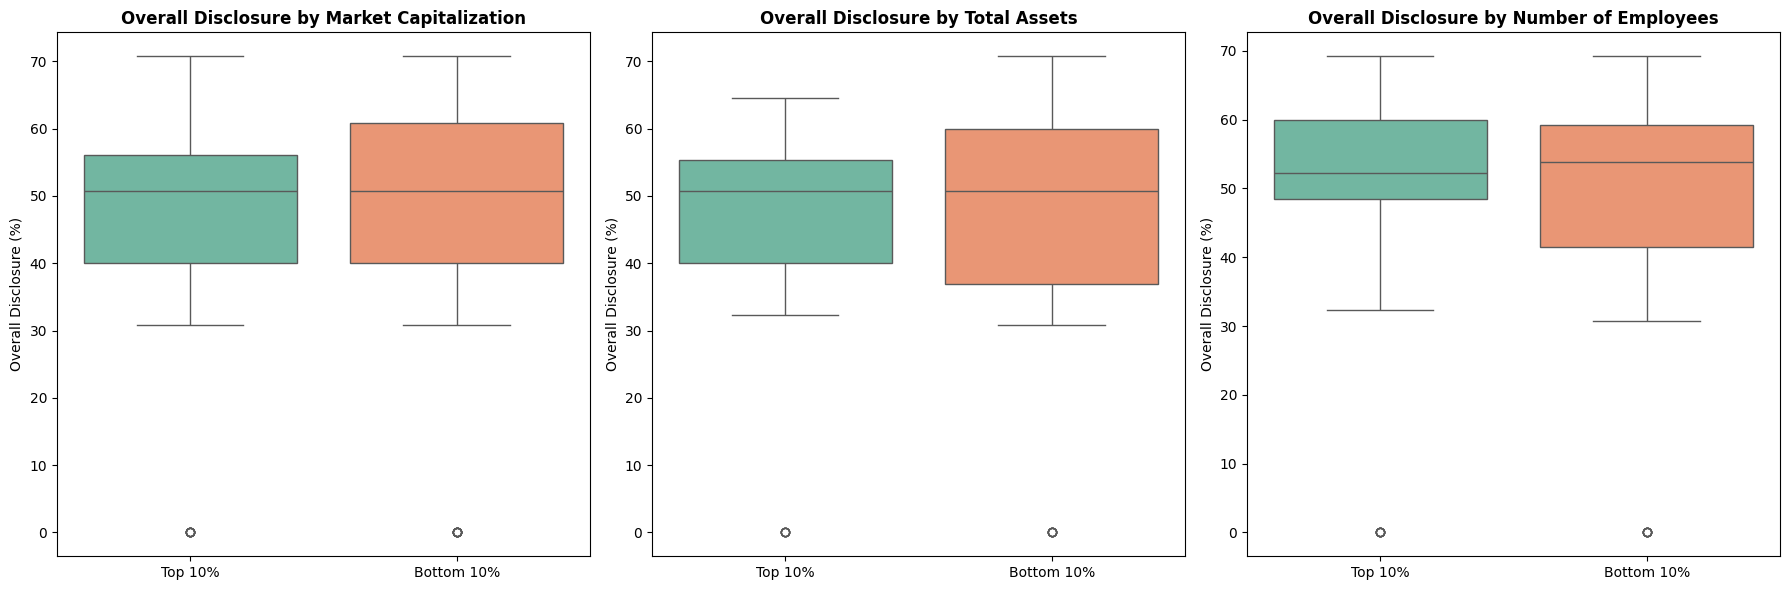

In [103]:
# --- Step 1: Create top/bottom 10% groups by each size metric ---
size_metrics = {
    "Market Capitalization": "Company Market Capitalization",
    "Total Assets": "Total Assets - Mean",
    "Number of Employees": "Number of Employees"
}

# Prepare an empty DataFrame for plotting
plot_df = pd.DataFrame()

for label, col in size_metrics.items():
    top_10 = aggregated_disclosure[aggregated_disclosure[col] >= aggregated_disclosure[col].quantile(0.9)].copy()
    bottom_10 = aggregated_disclosure[aggregated_disclosure[col] <= aggregated_disclosure[col].quantile(0.1)].copy()

    top_10['Group'] = 'Top 10%'
    bottom_10['Group'] = 'Bottom 10%'

    temp_df = pd.concat([top_10, bottom_10])
    temp_df['Metric'] = label
    plot_df = pd.concat([plot_df, temp_df])

# --- Step 2: Plot grid ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (label, col) in zip(axes, size_metrics.items()):
    sns.boxplot(
        x='Group',
        y='report_disclosure',
        data=plot_df[plot_df['Metric'] == label],
        palette="Set2",
        ax=ax
    )
    ax.set_title(f"Overall Disclosure by {label}", fontsize=12, weight="bold")
    ax.set_ylabel("Overall Disclosure (%)")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()


## 5. correlation with LSEG scores

Correlation matrix:
                                    report_disclosure  Social Pillar Score  \
report_disclosure                            1.000000            -0.009086   
Social Pillar Score                         -0.009086             1.000000   
Workforce Score                             -0.002881             0.718923   
ESG Score                                    0.006637             0.836531   
ESG Combined Score                           0.045243             0.608069   
CSR Sustainability Reporting Score           0.012394             0.198770   

                                    Workforce Score  ESG Score  \
report_disclosure                         -0.002881   0.006637   
Social Pillar Score                        0.718923   0.836531   
Workforce Score                            1.000000   0.648147   
ESG Score                                  0.648147   1.000000   
ESG Combined Score                         0.473908   0.712007   
CSR Sustainability Reporting Score   

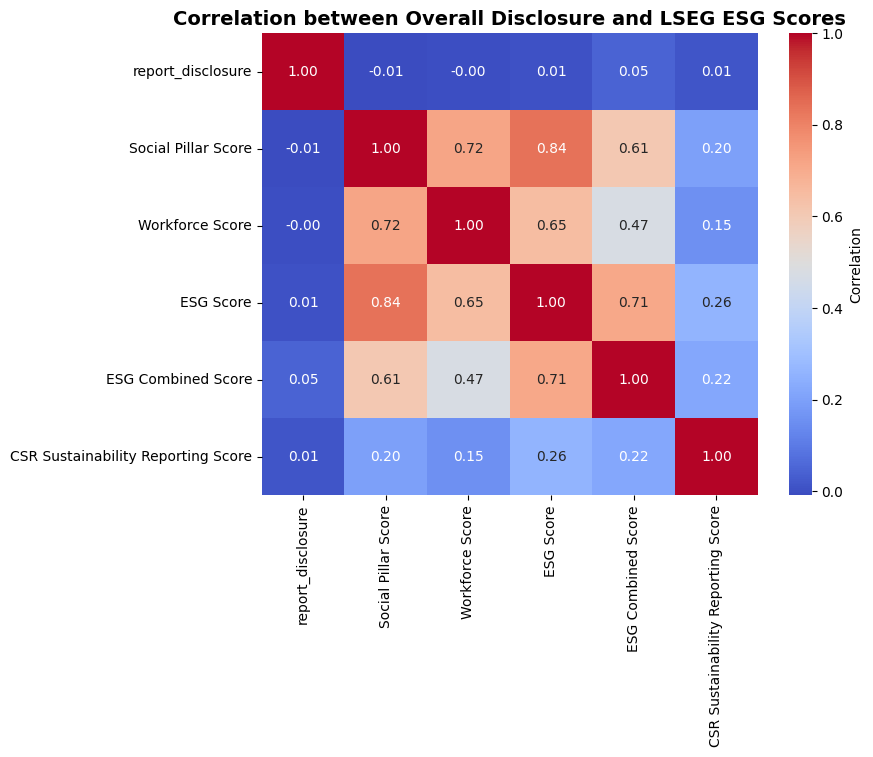

In [105]:
# --- Step 1: Select relevant columns ---
columns_of_interest = [
    "report_disclosure",      # your report disclosure
    "Social Pillar Score",
    "Workforce Score",
    "ESG Score",
    "ESG Combined Score",
    "CSR Sustainability Reporting Score"
]

df_corr = aggregated_disclosure[columns_of_interest].copy()

# --- Step 2: Compute correlation matrix ---
corr_matrix = df_corr.corr(method='pearson')  # Pearson correlation

# --- Step 3: Display as table ---
print("Correlation matrix:")
print(corr_matrix)

# --- Step 4: Optional: Heatmap for visualization ---
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Correlation'})
plt.title("Correlation between Overall Disclosure and LSEG ESG Scores", fontsize=14, weight="bold")
plt.show()


                                Score  Correlation
0                 Social Pillar Score    -0.009086
1                     Workforce Score    -0.002881
2                           ESG Score     0.006637
3                  ESG Combined Score     0.045243
4  CSR Sustainability Reporting Score     0.012394


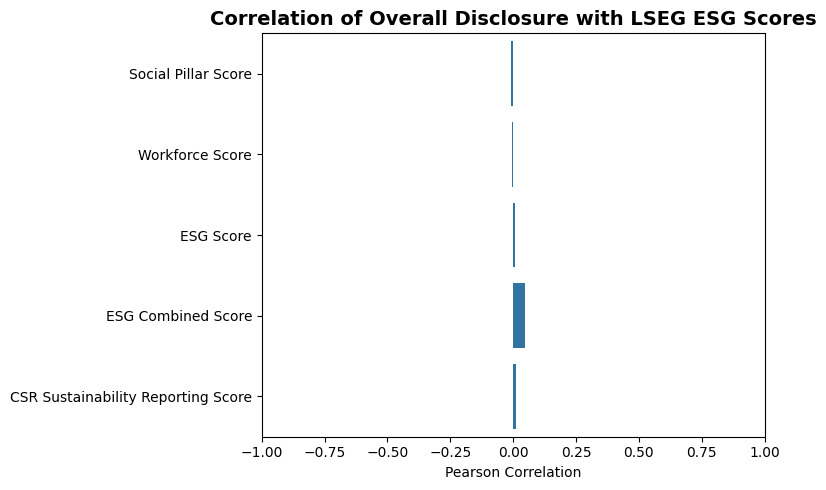

In [108]:
# --- Step 1: Define the columns to correlate with overall_disclosure ---
scores = ["Social Pillar Score", "Workforce Score", "ESG Score", "ESG Combined Score", "CSR Sustainability Reporting Score"]

# --- Step 2: Compute correlations ---
correlations = {}
for score in scores:
    corr = aggregated_disclosure["report_disclosure"].corr(aggregated_disclosure[score])
    correlations[score] = corr

# Convert to DataFrame for easy plotting
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation']).reset_index()
corr_df.rename(columns={'index': 'Score'}, inplace=True)

# --- Step 3: Display results ---
print(corr_df)

# --- Optional: visualize as bar plot ---
plt.figure(figsize=(8, 5))
sns.barplot(x='Correlation', y='Score', data=corr_df)
plt.xlim(-1, 1)
plt.title("Correlation of Overall Disclosure with LSEG ESG Scores", fontsize=14, weight="bold")
plt.xlabel("Pearson Correlation")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [ ]:
# --- Step 1: Define the columns to correlate with overall_disclosure ---
scores = ["Social Pillar Score", "Workforce Score", "ESG Score", "ESG Combined Score"]

# --- Step 2: Compute correlations ---
correlations = {}
for score in scores:
    corr = aggregated_disclosure["report_disclosure"].corr(aggregated_disclosure[score])
    correlations[score] = corr

# Convert to DataFrame for easy plotting
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation']).reset_index()
corr_df.rename(columns={'index': 'Score'}, inplace=True)

# --- Step 3: Display results ---
print(corr_df)

# --- Optional: visualize as bar plot ---
plt.figure(figsize=(8, 5))
sns.barplot(x='Correlation', y='Score', data=corr_df, palette='Blues_r')
plt.xlim(-1, 1)
plt.title("Correlation of Overall Disclosure with LSEG ESG Scores", fontsize=14, weight="bold")
plt.xlabel("Pearson Correlation")
plt.ylabel("")
plt.tight_layout()
plt.show()